# **PROJECT: WEATHER PREDICTIONS**

---
## Define the Problem

I want to predict the apparent temperatures, for the next 7 days, at a specific address in France, to assess how the weather conditions will feel there.

---
## Prepare the Tools

### Check the Documentation

* Python (https://docs.python.org/3.11/)
* Pandas (https://pandas.pydata.org/docs/)
* NumPy (https://numpy.org/doc/stable/)
* Matplotlib (https://matplotlib.org/stable/index.html
* Seaborn (https://seaborn.pydata.org/index.html)
* Scikit-Learn (https://scikit-learn.org/stable/index.html#)
* Location API (https://adresse.data.gouv.fr/api-doc/adresse)
* Weather API(https://open-meteo.com)

### Import Libraries and Modules

In [5]:
# Import librairies and modules

# To check my operating system
import os
# To manipulate, analyze and make calculations on the data
import pandas as pd
import numpy as np
# To handle the APIs (HTTP, Geocoding, Dates)
import requests
import folium
import datetime as dt
from dateutil.relativedelta import relativedelta
# To visualize the data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# To do Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### Define Functions

In [6]:
# Define functions

def check_directory():
    """
    Purpose:
        Check the current directory and its contents
    Parameters:
        None
    Result:
        Print of the current directory and its contents
    """
    
    try:
        current_directory = os.getcwd()
        print("CURRENT DIRECTORY")
        print()
        print(current_directory)
        print()
        print()
        print("FILES IN CURRENT DIRECTORY")
        print()
        files = os.listdir(current_directory)
        if files:
            for file in files:
                print(file)
            print()
            print()
        else:
            print("Files not found")
            print()
            print()
    except Exception as e:
        print(f"Error message: {e}")
        print()
        print()


def check_dataframe(dataframe):
    """
    Purpose:
        Check a dataframe to print detailed information about it
    Parameters:
        "dataframe" as a dataframe
    Result:
        Print of detailed information about the dataframe
    """
    
    try:
        print("GENERAL INFORMATION")
        print()
        print(dataframe.info())
        print()
        print()
        print("FIRST ROWS")
        print()
        print(dataframe.head())
        print()
        print()
        print("LAST ROWS")
        print()
        print(dataframe.tail())
        print()
        print()
        print("DUPLICATED ROWS")
        print()
        print(f"Count of duplicated rows: {dataframe.duplicated().sum()}")
        print()
        print()
        print("MISSING VALUES BY COLUMN")
        print()
        print(dataframe.isna().sum().reset_index(name = "missing_values_count").rename(columns = {"index": "column_name"}))
        print()
        print()
        print("UNIQUE VALUES BY COLUMN")
        print()
        print(dataframe.nunique().reset_index(name = "unique_values_count").rename(columns = {"index": "column_name"}))
        print()
        print()
        try:
            numeric_dataframe = dataframe.select_dtypes(include = "number")
            if not numeric_dataframe.empty:
                print("STATISTICS OF NUMERIC COLUMNS")
                print()
                print(numeric_dataframe.describe())
                print()
                print()
                print("CORRELATIONS OF NUMERIC COLUMNS")
                print()
                correlation_matrix = numeric_dataframe.corr()
                correlations_dict = {}
                for column in correlation_matrix.columns:
                    correlated_columns = []
                    for index in correlation_matrix.index:
                        if column != index:
                            correlation_value = correlation_matrix.at[index, column]
                            if 0.75 <= correlation_value < 1:
                                correlated_columns.append((index, correlation_value, "Very strong positive correlation"))
                            elif 0.50 <= correlation_value < 0.75:
                                correlated_columns.append((index, correlation_value, "Strong positive correlation"))
                            elif -0.75 <= correlation_value < -0.50:
                                correlated_columns.append((index, correlation_value, "Strong negative correlation"))
                            elif -1 <= correlation_value < -0.75:
                                correlated_columns.append((index, correlation_value, "Very strong negative correlation"))
                    if correlated_columns:
                        correlations_dict[column] = correlated_columns            
                for column in sorted(correlations_dict.keys()):
                    correlated_columns = correlations_dict[column]
                    correlated_columns_sorted = sorted(correlated_columns, key = lambda correlation_details: correlation_details[1], reverse = True)
                    print(f'"{column}":')
                    for correlated_column_name, correlation_value, correlation_type in correlated_columns_sorted:
                        print(f'- {correlation_type} ({correlation_value:.2f}) with "{correlated_column_name}"')
                    print()
            else:
                None
        except Exception as e:
            print(f"Error message: {e}")
            print()
            print()
    except Exception as e:
            print(f"Error message: {e}")
            print()
            print()


def check_distribution(dataframe, column_name):
    """
    Purpose: 
        Check the distribution of values in a column of a dataframe
    Parameters:
        "dataframe" as a dataframe
        "column_name" as a string
    Result:
        A dictionary containing statistics (range, Q1, Q2, spread, IQR, median, mean, mode(s),
        lower bound, upper bound, outliers and skewness)
    """
    
    # Calculate the range
    range = round(dataframe[column_name].max() - dataframe[column_name].min(), 2)
    
    # Calculate the spread (IQR)
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    spread = round(Q3 - Q1, 2)
    IQR = spread
    
    # Calculate the central tendency
    median = round(dataframe[column_name].median(), 2)
    mean = round(dataframe[column_name].mean(), 2)
    modes_list = dataframe[column_name].mode().to_list()
    rounded_modes_list = [round(mode, 2) for mode in modes_list]
    
    # Identify the outliers
    lower_bound = round(Q1 - 1.5 * IQR, 2)
    upper_bound = round(Q3 + 1.5 * IQR, 2)
    outliers_df = dataframe[(dataframe[column_name] < lower_bound) | (dataframe[column_name] > upper_bound)][column_name]
    if outliers_df.empty:
        outliers_list = "No outliers"
        outliers_count = 0
    else:
        outliers_list = outliers_df.tolist()
        outliers_count = len(outliers_df)
        
    # Calculate the skewness
    skewness = round(dataframe[column_name].skew(), 2)
    
    # Return the results in a dictionary
    return {
        "range": range,
        "Q1": Q1,
        "Q3": Q3,
        "spread": spread,
        "median": median,
        "mean": mean,
        "rounded_modes_list": rounded_modes_list,
        "IQR": IQR,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "outliers_list": outliers_list,
        "outliers_count": outliers_count,
        "skewness": skewness
    }


def visualize_boxplots_of_apparent_temperatures_distribution(year, dataframe):
    """
    Purpose: 
        Plot boxplots of the distribution of the apparent temperatures for a given year
    Parameters:
        "year" as a string
        "dataframe" as a dataframe
    Result:
        Boxplots of the distribution of the apparent temperatures for a given year
    """
    
    # Size the figure
    plt.figure(figsize = (12.5, 5))

    # Create boxplots of the distribution of the apparent temperatures for a given year
    plt.boxplot(
        [
            dataframe["apparent_temperature_max"],
            dataframe["apparent_temperature_mean"],
            dataframe["apparent_temperature_min"]
        ],
        labels = 
        [
            "Maximum \nApparent Temperature",
            "Mean \nApparent Temperature",
            "Minimum \nApparent Temperature"
        ]
    )
        
    # Customize the boxplots
    plt.grid(True, linestyle = "--")
    plt.xlabel("Apparent Temperature Types", fontstyle = "italic")
    plt.ylim(-15, 45)
    plt.ylabel("Apparent Temperatures (in °C)", fontstyle = "italic")
    plt.title(f"Distribution of Apparent Temperatures (in °C) in {year}", fontweight = "bold")
    
    # Show the figure
    plt.tight_layout()
    plt.show()
    print()


def visualize_histograms_of_apparent_temperatures_distribution_frequencies(year, dataframes_dict):
    """
    Purpose: 
        Plot histograms of the distribution frequencies of the apparent temperatures for a given year
    Parameters:
        "year" as a string
        "dataframes_dict" as a dictionary (strings as keys and tuples as values)
    Result:
        Histograms of the distribution frequencies of the apparent temperatures for a given year
    """
    
    # Size the figure
    plt.figure(figsize = (12.5, 5))

    # Create histograms of the distribution frequencies of the apparent temperatures for a given year
    for label, (color, dataframe) in dataframes_dict.items():
        hist, bins = np.histogram(dataframe, bins = 10, range = (min(dataframe), max(dataframe)))
        bin_width = bins[1] - bins[0]
        percentages = (hist / hist.sum()) * 100
        plt.bar(
            bins[:-1],
            percentages,
            width = bin_width,
            color = color,
            edgecolor = "black",
            alpha = 0.75,
            label = label,
            zorder = 2
        )

    # Customize the histograms
    plt.xlim(-15, 45)
    plt.xlabel("Apparent Temperatures (in °C)", fontstyle = "italic")
    plt.ylim(0, 25)
    plt.ylabel("Distribution Frequencies (in %)", fontstyle = "italic")
    plt.title(f"Distribution Frequencies of Apparent Temperatures (in °C) in {year}", fontweight = "bold")
    plt.legend()
    plt.grid(True, linestyle = "--", zorder = 0)

    # Show the figure
    plt.tight_layout()
    plt.show()
    print()


def visualize_lineplots_of_apparent_temperatures_patterns(year, dataframe):
    """
    Purpose: 
        Plot lineplots of the apparent temperatures patterns for a given year
    Parameters:
        "year" as a string
        "dataframe" as a dataframe
    Result:
        Lineplots of the apparent temperatures patterns for a given year
    """
    
    # Size the figure
    plt.figure(figsize = (12.5, 5))

    # Create lineplots of the apparent temperatures patterns for a given year
    plt.plot(
        dataframe["date"], 
        dataframe["apparent_temperature_max"], 
        color = "red", 
        label = "Maximum Apparent Temperature (in °C)"
    )
    plt.plot(
        dataframe["date"], 
        dataframe["apparent_temperature_mean"], 
        color = "grey", 
        label = "Mean Apparent Temperature (in °C)"
    )
    plt.plot(
        dataframe["date"], 
        dataframe["apparent_temperature_min"], 
        color = "blue", 
        label = "Minimum Apparent Temperature (in °C)"
    )
    
    # Customize the lineplots
    plt.legend()
    plt.grid(True, linestyle = "--")
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%B\n%Y"))
    plt.xlabel("Month", fontstyle = "italic")
    plt.ylim(-15, 45)
    plt.ylabel("Apparent Temperatures (in °C)", fontstyle = "italic")
    plt.title(f"Apparent Temperatures (in °C) by Month in {year}", fontweight = "bold")

    # Show the figure
    plt.tight_layout()
    plt.show()
    print()

### Check the Current Directory

In [7]:
# Check the directory
check_directory()

CURRENT DIRECTORY

C:\Users\willi\data_resources\portfolio\weather_project


FILES IN CURRENT DIRECTORY

.ipynb_checkpoints
mini_project_weather_predictions_v1.ipynb
mini_project_weather_predictions_v2.ipynb
mini_project_weather_predictions_v3.ipynb
mini_project_weather_predictions_v4.ipynb
mini_project_weather_predictions_v5.ipynb
mini_project_weather_predictions_v6.ipynb
mini_project_weather_predictions_v7.ipynb
mini_project_weather_predictions_v8.ipynb




---
## Collect the Data

### On the Location

In [31]:
# Prepare the API endpoint for location data
location_address = input("ADRESS (format: 1 Rue Ernest Roschach, 31000 Toulouse)\n\n")
print()
print()
location_api_root_url = "https://api-adresse.data.gouv.fr/search/?q="
formatted_location_address = location_address.replace(" ", "+").replace(",", "%2C")
location_api_endpoint = location_api_root_url + formatted_location_address

# Access the API to return the latitude, longitude and a map of the location
try:
    location_api_response = requests.get(location_api_endpoint)
    if location_api_response.status_code == 200:        
        location_address_dict = location_api_response.json()               
        if "features" in location_address_dict and len(location_address_dict["features"]) > 0:
            location_coordinates = location_address_dict["features"][0]["geometry"]["coordinates"][::-1]
            location_latitude = location_coordinates[0]
            location_longitude = location_coordinates[1]
            print("ADDRESS COORDINATES")
            print()
            print(f"Latitude: {location_latitude}")
            print(f"Longitude: {location_longitude}")
            print()
            print()
            
            folium_map = folium.Map(
                location = [location_latitude, location_longitude],
                zoom_start = 15
            )
            folium.Marker(
                location = [location_latitude, location_longitude],
                popup = location_address
            ).add_to(folium_map)
            print("INTERACTIVE MAP")
            print()
            display(folium_map)
        else:
            print("Coordinates not found")
    else:
        print(f"Error: Status code {location_api_response.status_code}")
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")

ADRESS (format: 1 Rue Ernest Roschach, 31000 Toulouse)

 1 Rue Ernest Roschach, 31000 Toulouse




ADDRESS COORDINATES

Latitude: 43.604468
Longitude: 1.444639


INTERACTIVE MAP



### On the Daily Weather Characteristics

In [32]:
# Prepare the API endpoint for daily weather data
date_today = dt.datetime.now()
date_5_years_ago = date_today - relativedelta(years = 5)
formatted_date_today = date_today.strftime("%Y-%m-%d")
formatted_date_5_years_ago = date_5_years_ago.strftime("%Y-%m-%d")
daily_weather_api_endpoint = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={location_latitude}&longitude={location_longitude}&"
    f"start_date={formatted_date_5_years_ago}&"
    f"end_date={formatted_date_today}&"
    "daily=weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,"
    "apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,"
    "sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,"
    "wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&"
    "timezone=Europe%2FLondon&"
)

# Access the API to return daily weather data
try:
    # Get the API response
    daily_weather_api_response = requests.get(daily_weather_api_endpoint)

    # Check if the request was successful (status code: 200)
    if daily_weather_api_response.status_code == 200:
        # Parse the JSON response into a Python dictionary
        daily_weather_dict = daily_weather_api_response.json()
        # Extract daily data
        daily_weather_dict = daily_weather_dict["daily"]
        # Convert the Python dictionary into a DataFrame
        daily_weather_df = pd.DataFrame(daily_weather_dict)

        # Check data
        check_dataframe(daily_weather_df)

    else:
        print(f"Error: Status code {daily_weather_api_response.status_code}")

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   time                         1828 non-null   object 
 1   weather_code                 1827 non-null   float64
 2   temperature_2m_max           1827 non-null   float64
 3   temperature_2m_min           1827 non-null   float64
 4   temperature_2m_mean          1826 non-null   float64
 5   apparent_temperature_max     1827 non-null   float64
 6   apparent_temperature_min     1827 non-null   float64
 7   apparent_temperature_mean    1826 non-null   float64
 8   sunrise                      1828 non-null   object 
 9   sunset                       1828 non-null   object 
 10  daylight_duration            1828 non-null   float64
 11  sunshine_duration            1826 non-null   float64
 12  precipitation_sum            1826 non-null   float64
 1

MEANING OF COLUMNS

* "time": Date of the record (iso8601; year-month-day).
  
* "weather_code": Type of weather (WMO code).

* "temperature_2m_max": Maximum temperature at 2 meters above ground (°C).

* "temperature_2m_min": Minimum temperature at 2 meters above ground (°C).

* "temperature_2m_mean": Mean temperature at 2 meters above ground (°C).

* "apparent_temperature_max": Maximum apparent temperature (°C).

* "apparent_temperature_min": Minimum apparent temperature (°C).

* "apparent_temperature_mean": Mean apparent temperature (°C).

* "sunrise": Time of the sunrise (iso8601; year-month-dayThour:minute).

* "sunset": Time of the sunrise (iso8601; year-month-dayThour:minute).

* "daylight_duration": Duration of daylight (seconds).

* "sunshine_duration": Duration of sunshine (seconds).

* "precipitation_sum": Sum of precipitation (mm; rain showers and snowfalls).

* "rain_sum": Sum of rain (mm).

* "snowfall_sum": Sum of snowfall (cm).

* "precipitation_hours": Duration of precipitation (hours).

* "wind_speed_10m_max": Maximum wind speed at 10 meters above ground (km/h; average over a few minutes).

* "wind_gusts_10m_max": Maximum wind gust at 10 meters above ground (km/h; maximum over a few seconds).

* "wind_direction_10m_dominant": Dominant wind direction at 10 meters above ground (°).

* "shortwave_radiation_sum": Sum of solar radiation (MJ/m²).

* "et0_fao_evapotranspiration": Sum of ET₀ Reference Evapotranspiration of a well watered grass field (mm).

### On the Hourly Weather Characteristics

In [33]:
# Prepare the API endpoint for hourly weather data
date_today = dt.datetime.now()
date_5_years_ago = date_today - relativedelta(years = 5)
formatted_date_today = date_today.strftime("%Y-%m-%d")
formatted_date_5_years_ago = date_5_years_ago.strftime("%Y-%m-%d")
hourly_weather_api_endpoint = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={location_latitude}&longitude={location_longitude}&"
    f"start_date={formatted_date_5_years_ago}&"
    f"end_date={formatted_date_today}&"
    "hourly=relative_humidity_2m,dew_point_2m,pressure_msl,cloud_cover,"
    "direct_radiation,direct_normal_irradiance,diffuse_radiation,global_tilted_irradiance,"
    "wind_speed_100m,wind_direction_100m,vapour_pressure_deficit,"
    "soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,"
    "soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,"
    "soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm&"
    "timezone=Europe%2FLondon&"
)

# Access the API to return hourly weather data
try:
    # Get the API response
    hourly_weather_api_response = requests.get(hourly_weather_api_endpoint)

    # Check if the request was successful (status code: 200)
    if hourly_weather_api_response.status_code == 200:
        # Parse the JSON response into a Python dictionary
        hourly_weather_dict = hourly_weather_api_response.json()
        # Extract hourly data
        hourly_weather_dict = hourly_weather_dict["hourly"]
        # Convert the Python dictionary into a DataFrame
        hourly_weather_df = pd.DataFrame(hourly_weather_dict)

        # Check data
        check_dataframe(hourly_weather_df)

    else:
        print(f"Error: Status code {weather_api_response.status_code}")

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43872 entries, 0 to 43871
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   time                           43872 non-null  object 
 1   relative_humidity_2m           43826 non-null  float64
 2   dew_point_2m                   43826 non-null  float64
 3   pressure_msl                   43826 non-null  float64
 4   cloud_cover                    43826 non-null  float64
 5   direct_radiation               43826 non-null  float64
 6   direct_normal_irradiance       43826 non-null  float64
 7   diffuse_radiation              43826 non-null  float64
 8   global_tilted_irradiance       43826 non-null  float64
 9   wind_speed_100m                43826 non-null  float64
 10  wind_direction_100m            43826 non-null  float64
 11  vapour_pressure_deficit        43826 non-null  float64
 12  soil_temperature_0_to_7cm

MEANING OF COLUMNS

* "time": Date of the record (iso8601; year-month-dayThour:minute).

* "relative_humidity_2m": Relative humidity at 2 meters above ground (%).

* "dew_point_2m": Dew point temperature at 2 meters above ground (°C).

* "pressure_msl": Atmospheric air pressure reduced to mean sea level (hPa).

* "cloud_cover": Total cloud cover as an area fraction (%).

* "direct_radiation": Direct solar radiation as average of the preceding hour on the horizontal plane (W/m²).

* "direct_normal_irradiance": Direct solar radiation as average of the preceding hour on the normal plane (W/m²).

* "diffuse_radiation": Diffuse solar radiation as average of the preceding hour (W/m²).

* "global_tilted_irradiance": Total radiation received on a tilted pane as average of the preceding hour. The calculation is assuming a fixed albedo of 20% and in isotropic sky (W/m²).

* "wind_speed_100m": Wind speed at 100 meters above ground (km/h).

* "wind_direction_100m": Wind direction at 100 meters above ground (km/h).

* "vapour_pressure_deficit": Vapor Pressure Deificit (kPa).

* "soil_temperature_0_to_7cm": Average temperature from 0 to 7cm below ground (cm).

* "soil_temperature_7_to_28cm": Average temperature from 7 to 28cm below ground (cm).

* "soil_temperature_28_to_100cm": Average temperature from 28 to 100cm below ground (cm).

* "soil_temperature_100_to_255cm": Average temperature from 100 to 255cm below ground (cm).

* "soil_moisture_0_to_7cm": Average soil water content as volumetric mixing ratio from 0 to 7cm below ground (m3/m3).

* "soil_moisture_7_to_28cm": Average soil water content as volumetric mixing ratio from 7 to 28cm below ground (m3/m3).

* "soil_moisture_28_to_100cm": Average soil water content as volumetric mixing ratio from 28 to 100cm below ground (m3/m3).

* "soil_moisture_100_to_255cm": Average soil water content as volumetric mixing ratio from 100 to 255cm below ground (m3/m3).

---
## Clean and Prepare the Data

### On the Daily Weather Characteristics

In [34]:
# Save the dataframe
daily_weather_cleaned_df = daily_weather_df.copy()

# Handle the missing values
date_today = dt.datetime.now()
date_yesterday = date_today - relativedelta(days = 1)
formatted_date_today = date_today.strftime("%Y-%m-%d")
formatted_date_yesterday = date_yesterday.strftime("%Y-%m-%d")
daily_weather_cleaned_df["time"] = pd.to_datetime(daily_weather_cleaned_df["time"], format = "%Y-%m-%d")
daily_weather_cleaned_df["date"] = daily_weather_cleaned_df["time"].dt.strftime("%Y-%m-%d")
daily_weather_cleaned_df = daily_weather_cleaned_df[~daily_weather_cleaned_df["date"].isin([formatted_date_today, formatted_date_yesterday])]

# Drop a useless column
daily_weather_cleaned_df.drop(columns = ["time"], inplace = True)

# Format the value types
daily_weather_cleaned_df["date"] = pd.to_datetime(daily_weather_cleaned_df["date"], format = "%Y-%m-%d")
daily_weather_cleaned_df["sunrise"] = pd.to_datetime(daily_weather_cleaned_df["sunrise"], format = "%Y-%m-%dT%H:%M")
daily_weather_cleaned_df["sunset"] = pd.to_datetime(daily_weather_cleaned_df["sunset"], format = "%Y-%m-%dT%H:%M")

# Check the daily weather cleaned dataframe
check_dataframe(daily_weather_cleaned_df)

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   weather_code                 1826 non-null   float64       
 1   temperature_2m_max           1826 non-null   float64       
 2   temperature_2m_min           1826 non-null   float64       
 3   temperature_2m_mean          1826 non-null   float64       
 4   apparent_temperature_max     1826 non-null   float64       
 5   apparent_temperature_min     1826 non-null   float64       
 6   apparent_temperature_mean    1826 non-null   float64       
 7   sunrise                      1826 non-null   datetime64[ns]
 8   sunset                       1826 non-null   datetime64[ns]
 9   daylight_duration            1826 non-null   float64       
 10  sunshine_duration            1826 non-null   float64       
 11  precipitation_sum          

In [35]:
# Add useful columns
daily_weather_cleaned_df["day"] = daily_weather_cleaned_df["date"].dt.day
daily_weather_cleaned_df["month"] = daily_weather_cleaned_df["date"].dt.strftime("%B")
daily_weather_cleaned_df["year"] = daily_weather_cleaned_df["date"].dt.year

# Format the value types
daily_weather_cleaned_df["day"] = pd.to_numeric(daily_weather_cleaned_df["day"])
daily_weather_cleaned_df["year"] = pd.to_numeric(daily_weather_cleaned_df["year"])

# Check the daily weather cleaned dataframe
check_dataframe(daily_weather_cleaned_df)

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 1825
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   weather_code                 1826 non-null   float64       
 1   temperature_2m_max           1826 non-null   float64       
 2   temperature_2m_min           1826 non-null   float64       
 3   temperature_2m_mean          1826 non-null   float64       
 4   apparent_temperature_max     1826 non-null   float64       
 5   apparent_temperature_min     1826 non-null   float64       
 6   apparent_temperature_mean    1826 non-null   float64       
 7   sunrise                      1826 non-null   datetime64[ns]
 8   sunset                       1826 non-null   datetime64[ns]
 9   daylight_duration            1826 non-null   float64       
 10  sunshine_duration            1826 non-null   float64       
 11  precipitation_sum          

### On the Hourly Weather Characteristics

In [37]:
# Save the dataframe
hourly_weather_cleaned_df = hourly_weather_df.copy()

# Handle the missing values
date_today = dt.datetime.now()
date_yesterday = date_today - relativedelta(days = 1)
formatted_date_today = date_today.strftime("%Y-%m-%d")
formatted_date_yesterday = date_yesterday.strftime("%Y-%m-%d")
hourly_weather_cleaned_df["time"] = pd.to_datetime(hourly_weather_cleaned_df["time"], format = "%Y-%m-%dT%H:%M")
hourly_weather_cleaned_df["date"] = hourly_weather_cleaned_df["time"].dt.strftime("%Y-%m-%d")
hourly_weather_cleaned_df = hourly_weather_cleaned_df[~hourly_weather_cleaned_df["date"].isin([formatted_date_today, formatted_date_yesterday])]

# Drop a useless column
hourly_weather_cleaned_df.drop(columns = ["time"], inplace = True)

# Format the value types
hourly_weather_cleaned_df["date"] = pd.to_datetime(hourly_weather_cleaned_df["date"], format = "%Y-%m-%d")

# Check the hourly weather cleaned dataframe
check_dataframe(hourly_weather_cleaned_df)

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 0 to 43823
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   relative_humidity_2m           43824 non-null  float64       
 1   dew_point_2m                   43824 non-null  float64       
 2   pressure_msl                   43824 non-null  float64       
 3   cloud_cover                    43824 non-null  float64       
 4   direct_radiation               43824 non-null  float64       
 5   direct_normal_irradiance       43824 non-null  float64       
 6   diffuse_radiation              43824 non-null  float64       
 7   global_tilted_irradiance       43824 non-null  float64       
 8   wind_speed_100m                43824 non-null  float64       
 9   wind_direction_100m            43824 non-null  float64       
 10  vapour_pressure_deficit        43824 non-null  float64       
 11 

In [38]:
# Group by date to calculate the mean of hourly values for each day
hourly_weather_numeric_columns_list = hourly_weather_cleaned_df.select_dtypes(include = ["number"]).columns
added_daily_weather_cleaned_df = hourly_weather_cleaned_df.groupby("date")[hourly_weather_numeric_columns_list].mean().reset_index()

# Add useful columns
added_daily_weather_cleaned_df["day"] = hourly_weather_cleaned_df["date"].dt.day
added_daily_weather_cleaned_df["month"] = hourly_weather_cleaned_df["date"].dt.strftime("%B")
added_daily_weather_cleaned_df["year"] = hourly_weather_cleaned_df["date"].dt.year

# Format value types
added_daily_weather_cleaned_df["day"] = pd.to_numeric(added_daily_weather_cleaned_df["day"])
added_daily_weather_cleaned_df["year"] = pd.to_numeric(added_daily_weather_cleaned_df["year"])

# Check the added daily weather cleaned dataframe
check_dataframe(added_daily_weather_cleaned_df)

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           1826 non-null   datetime64[ns]
 1   relative_humidity_2m           1826 non-null   float64       
 2   dew_point_2m                   1826 non-null   float64       
 3   pressure_msl                   1826 non-null   float64       
 4   cloud_cover                    1826 non-null   float64       
 5   direct_radiation               1826 non-null   float64       
 6   direct_normal_irradiance       1826 non-null   float64       
 7   diffuse_radiation              1826 non-null   float64       
 8   global_tilted_irradiance       1826 non-null   float64       
 9   wind_speed_100m                1826 non-null   float64       
 10  wind_direction_100m            1826 non-null   float64       
 

### On the Merged Daily Weather Characteristics

In [39]:
# Merge both daily weather dataframes
weather_df = daily_weather_cleaned_df.merge(added_daily_weather_cleaned_df, on = "date")

# Check merged data
check_dataframe(weather_df)

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   weather_code                   1826 non-null   float64       
 1   temperature_2m_max             1826 non-null   float64       
 2   temperature_2m_min             1826 non-null   float64       
 3   temperature_2m_mean            1826 non-null   float64       
 4   apparent_temperature_max       1826 non-null   float64       
 5   apparent_temperature_min       1826 non-null   float64       
 6   apparent_temperature_mean      1826 non-null   float64       
 7   sunrise                        1826 non-null   datetime64[ns]
 8   sunset                         1826 non-null   datetime64[ns]
 9   daylight_duration              1826 non-null   float64       
 10  sunshine_duration              1826 non-null   float64       
 

In [40]:
# Save the dataframe
weather_cleaned_df = weather_df.copy()

# Drop useless columns
weather_cleaned_df.drop(columns = ["day_y", "month_y", "year_y"], inplace = True)

# Rename useful columns
renamed_columns_dict = {
    "day_x": "day",
    "month_x": "month",
    "year_x": "year"
}
weather_cleaned_df.rename(columns = renamed_columns_dict, inplace = True)

# Check cleaned data
check_dataframe(weather_cleaned_df)

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   weather_code                   1826 non-null   float64       
 1   temperature_2m_max             1826 non-null   float64       
 2   temperature_2m_min             1826 non-null   float64       
 3   temperature_2m_mean            1826 non-null   float64       
 4   apparent_temperature_max       1826 non-null   float64       
 5   apparent_temperature_min       1826 non-null   float64       
 6   apparent_temperature_mean      1826 non-null   float64       
 7   sunrise                        1826 non-null   datetime64[ns]
 8   sunset                         1826 non-null   datetime64[ns]
 9   daylight_duration              1826 non-null   float64       
 10  sunshine_duration              1826 non-null   float64       
 

---
## Explore and Analyze the Data

### On the Apparent Temperatures

#### Visualize the Correlations

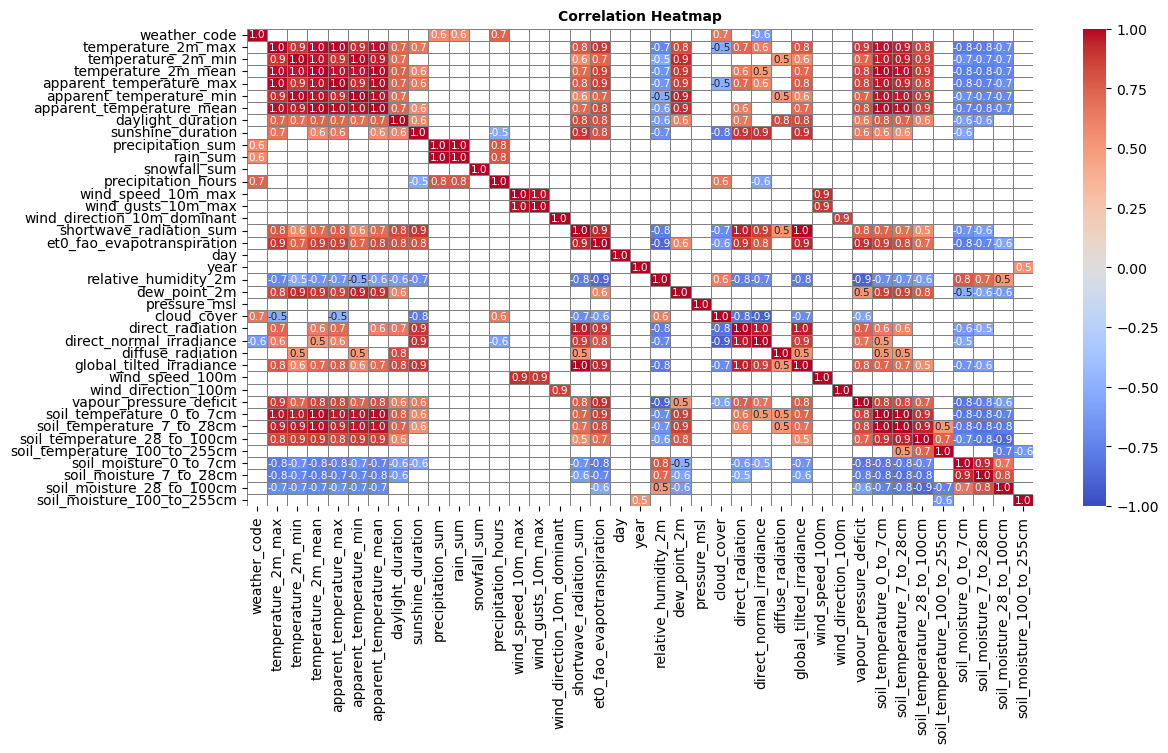

In [44]:
# Size the figure
plt.figure(figsize = (12.5, 7.5))

# Plot a Correlation Heatmap (without insignificant correlations)
correlation_matrix = weather_cleaned_df.select_dtypes(include = ["number"]).corr()
mask = np.abs(correlation_matrix) <= 0.50
correlation_heatmap = sns.heatmap(correlation_matrix,
                                  mask = mask,
                                  fmt=".1f",
                                  annot = True,
                                  annot_kws = {"size": 7.5},
                                  linecolor = "grey",
                                  linewidth = 0.5,
                                  vmin = -1,
                                  vmax = 1,                                  
                                  cmap = "coolwarm")

# Show the figure
plt.tight_layout()
plt.title("Correlation Heatmap", fontsize = 10, fontweight = "bold")
plt.show()

#### Comment the Correlations

* Very strong positive correlation between "apparent_temperatures" (max, mean, and min) and "temperatures" (max, mean, and min). 
This indicates that apparent temperatures increase with actual temperatures. 
This makes sense because apparent temperatures are influenced by actual temperatures and other factors affecting temperatures perception.

* Very strong positive correlation between "apparent_temperatures" (max, mean, and min) and "shortwave_radiation_sum". 
This indicates that apparent temperatures increase with higher shortwave solar radiation. 
This makes sense because shortwave radiation heats the Earth's surface and atmosphere.

* Very strong positive correlation between "apparent_temperatures" (max, mean, and min) and "global_tilted_irradiance". 
This indicates that apparent temperatures increase with higher global tilted irradiance. 
This makes sense because global tilted irradiance measures the solar energy absorbed by the ground and surfaces.

* Very strong positive correlation between "apparent_temperatures" (max, mean, and min) and "soil_temperatures" (0 to 100 cm). 
This indicates that apparent temperatures increase with soil temperatures.
This makes sense because the soil absorbs solar energy and releases heat into the atmosphere.

* Very strong positive correlation between "apparent_temperatures" (max, mean, and min) and "dew_point_2m". 
This indicates that apparent temperatures increase with higher dew point.
This makes sense because the dew point reflects moisture levels in the air.

* Very strong positive correlation between "apparent_temperatures" (max, mean, and min) and "vapour_pressure_deficit".
This indicates that apparent temperatures increase with higher vapor pressure deficit.
This makes sense because vapor pressure deficit is the difference between the moisture the atmosphere can hold and what is actually present.

* Very strong positive correlation between "apparent_temperatures" (max, mean, and min) and "et0_fao_evapotranspiration".
This indicates that apparent temperatures increase with higher evapotranspiration.
This makes sense because evapotranspiration is the evaporation of water from the ground and plants caused by the heat and solar energy.

* Very strong negative correlation between "apparent_temperatures" (max, mean, and min) and "soil_moisture" (0 to 100 cm). 
This indicates that apparent temperatures increase with lower soil moisture. 
This makes sense because the soil absorbs solar energy, heats up, evaporates moisture (cooling down), then releases heat into the atmosphere.

* Strong positive correlation between "apparent_temperatures" (max, mean, and min) and "daylight_duration". 
This indicates that apparent temperatures increase with longer daylight durations. 
This makes sense because daylight durations influence how long the Earth's surface is exposed to solar energy.

* Strong positive correlation between "apparent_temperatures" (max, mean, and min) and "sunshine_duration". 
This indicates that apparent temperatures increase with longer sunshine durations. 
This makes sense because sunshine durations influence how long the Earth's surface is exposed to direct solar energy.

* Strong positive correlation between "apparent_temperatures" (max, mean, and min) and "direct_radiation". 
This indicates that apparent temperatures increase with higher direct radiation.
This makes sense because direct radiation heats the Earth's surface and atmosphere.

* Strong positive correlation between "apparent_temperatures" (max, mean, and min) and "direct_normal_irradiance". 
This indicates that apparent temperatures increase with higher direct normal irradiance.
This makes sense because direct normal irradiance measures the solar energy directly hitting the Earth's surface.

* Strong negative correlation between "apparent_temperatures" (max, mean, and min) and "cloud_cover". 
This indicates that apparent temperatures increase with lower cloud cover.
This makes sense because cloud cover allows or blocks some solar radiation to reach the Earth's surface.

* Strong negative correlation between "apparent_temperatures" (max, mean, and min) and "relative_humidity_2m".
This indicates that apparent temperatures increase with lower relative humidity.
This makes sense because humidity absorbs heat.

#### Visualize the Distributions for each year

In [45]:
# Filter weather data by year
year_2019_weather_cleaned_df = weather_cleaned_df[weather_cleaned_df["year"] == 2019]
year_2020_weather_cleaned_df = weather_cleaned_df[weather_cleaned_df["year"] == 2020]
year_2021_weather_cleaned_df = weather_cleaned_df[weather_cleaned_df["year"] == 2021]
year_2022_weather_cleaned_df = weather_cleaned_df[weather_cleaned_df["year"] == 2022]
year_2023_weather_cleaned_df = weather_cleaned_df[weather_cleaned_df["year"] == 2023]
year_2024_weather_cleaned_df = weather_cleaned_df[weather_cleaned_df["year"] == 2024]

# List the years and their corresponding dataframes
years_of_weather_cleaned_df = ["2024 (partial year)", "2023", "2022", "2021", "2020", "2019 (partial year)"]
weather_cleaned_dfs_by_year = [
    year_2024_weather_cleaned_df,
    year_2023_weather_cleaned_df,
    year_2022_weather_cleaned_df,     
    year_2021_weather_cleaned_df,
    year_2020_weather_cleaned_df, 
    year_2019_weather_cleaned_df
]

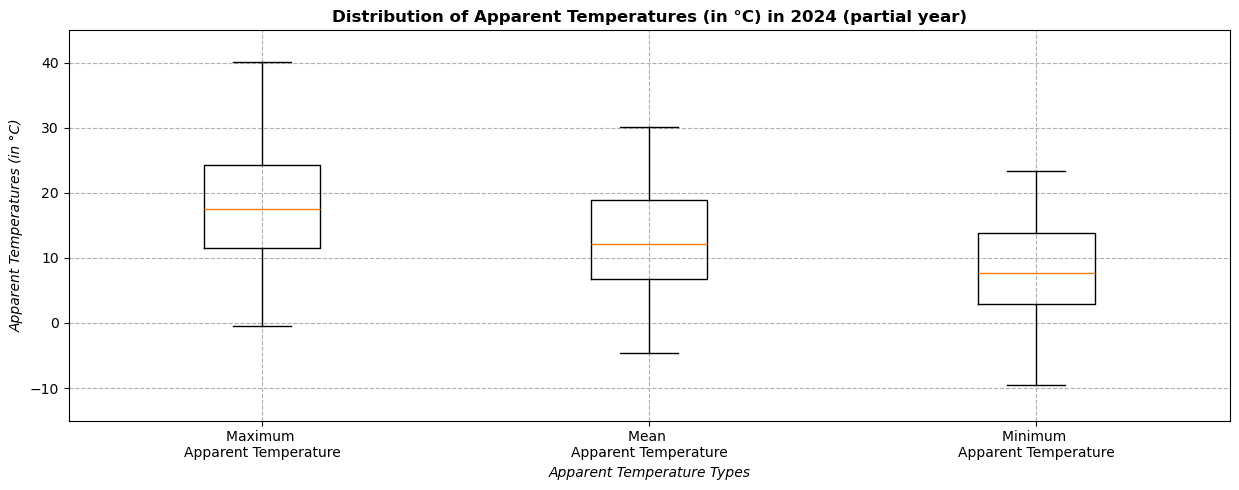

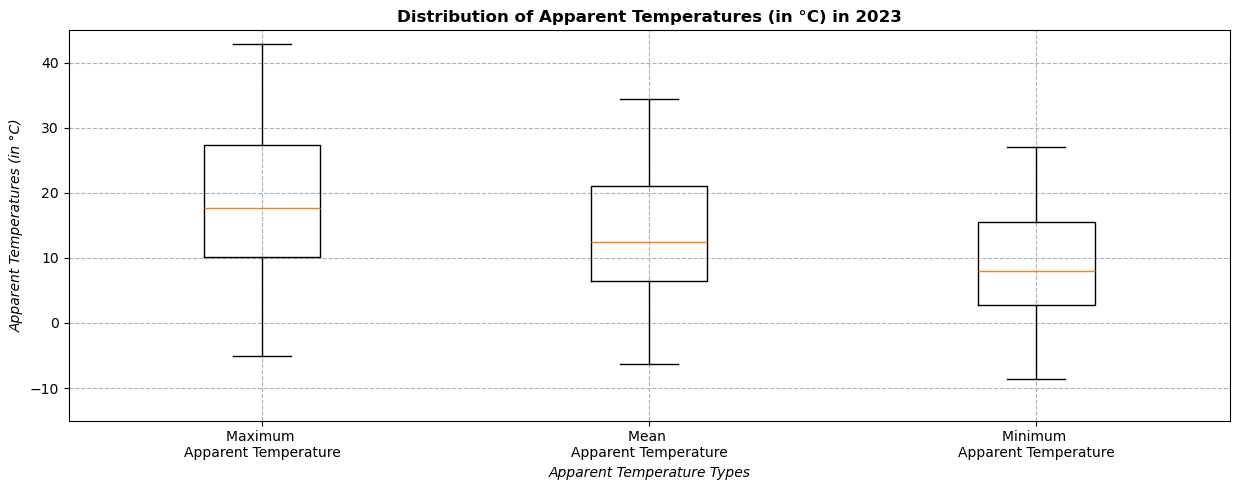

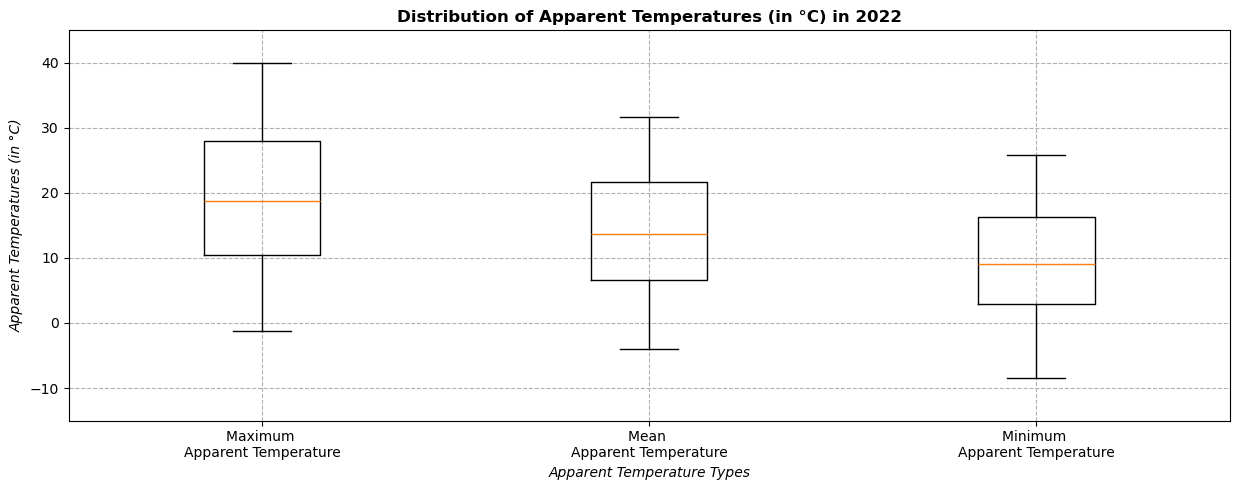

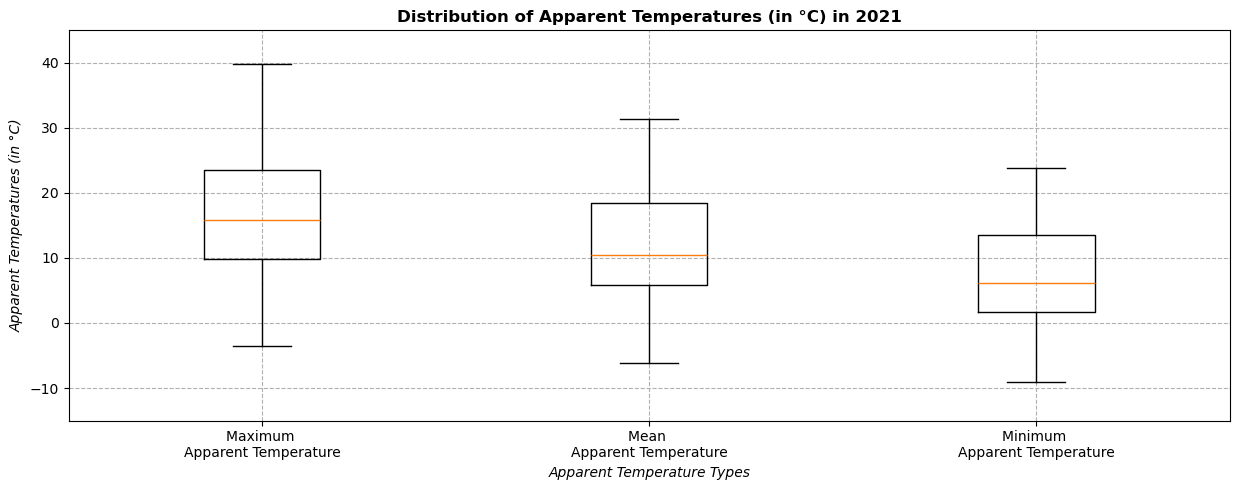

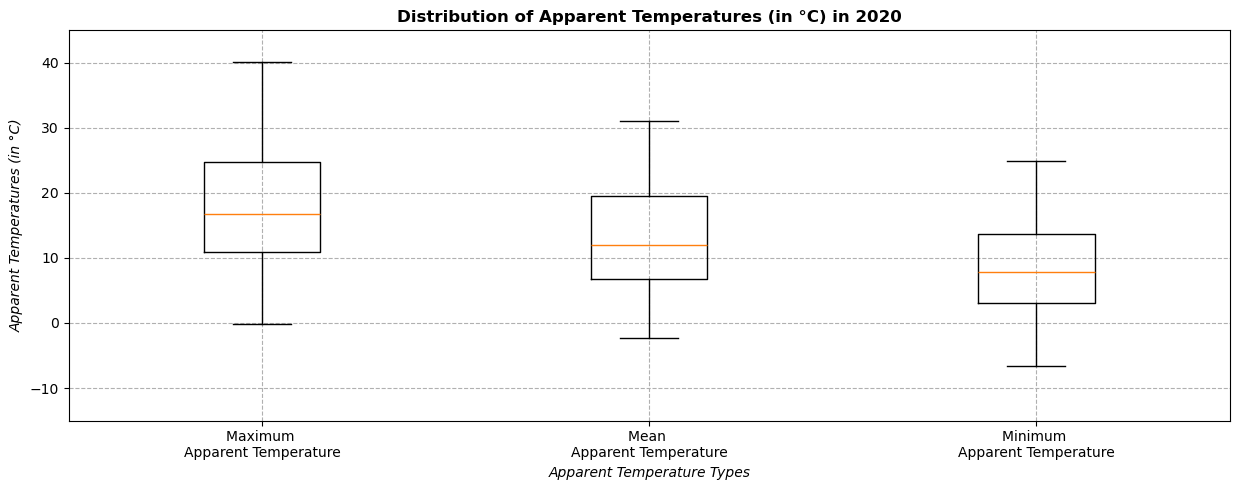

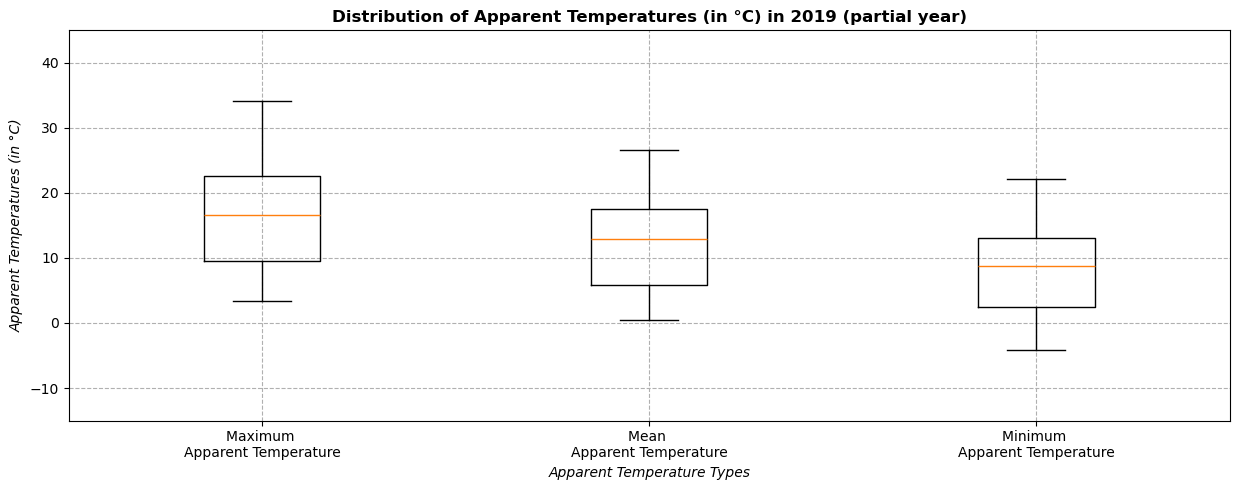

In [46]:
# Loop through each year and its corresponding dataframe to plot boxplots of apparent temperatures distributions
for year_of_weather_cleaned_df, weather_cleaned_df_by_year in zip(years_of_weather_cleaned_df, weather_cleaned_dfs_by_year):
    visualize_boxplots_of_apparent_temperatures_distribution(year_of_weather_cleaned_df, weather_cleaned_df_by_year)

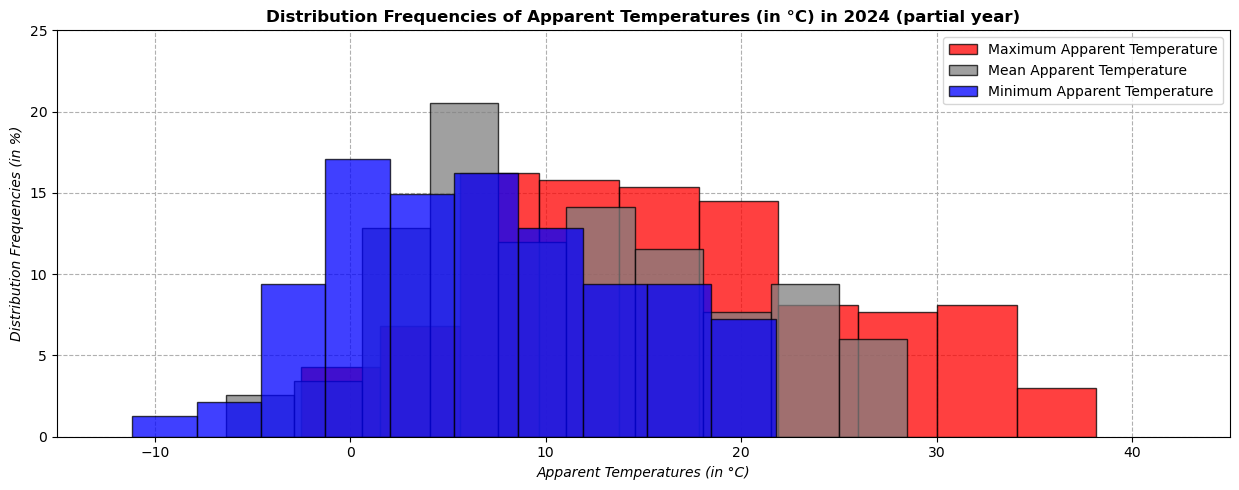

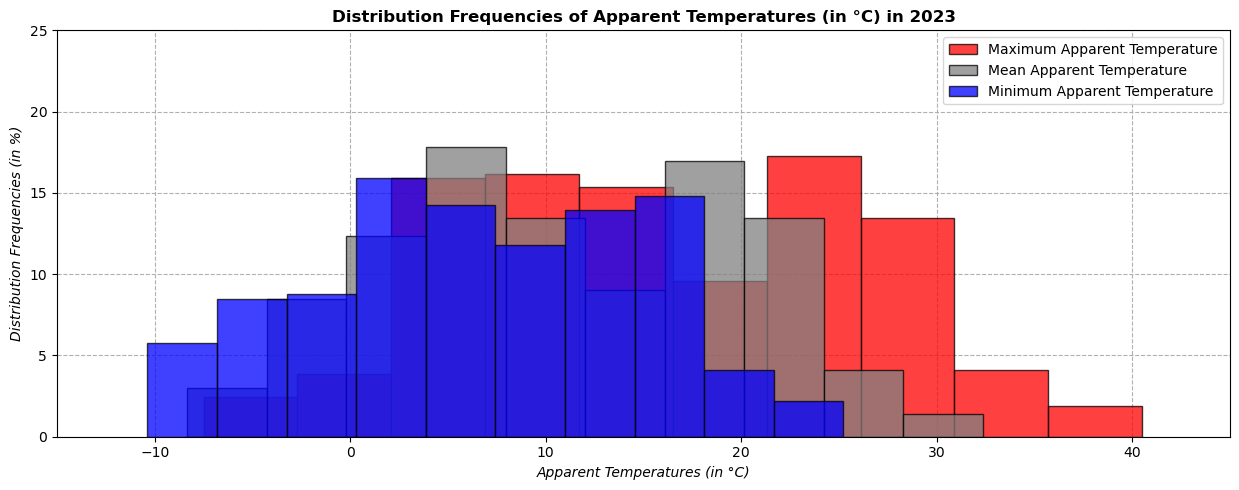

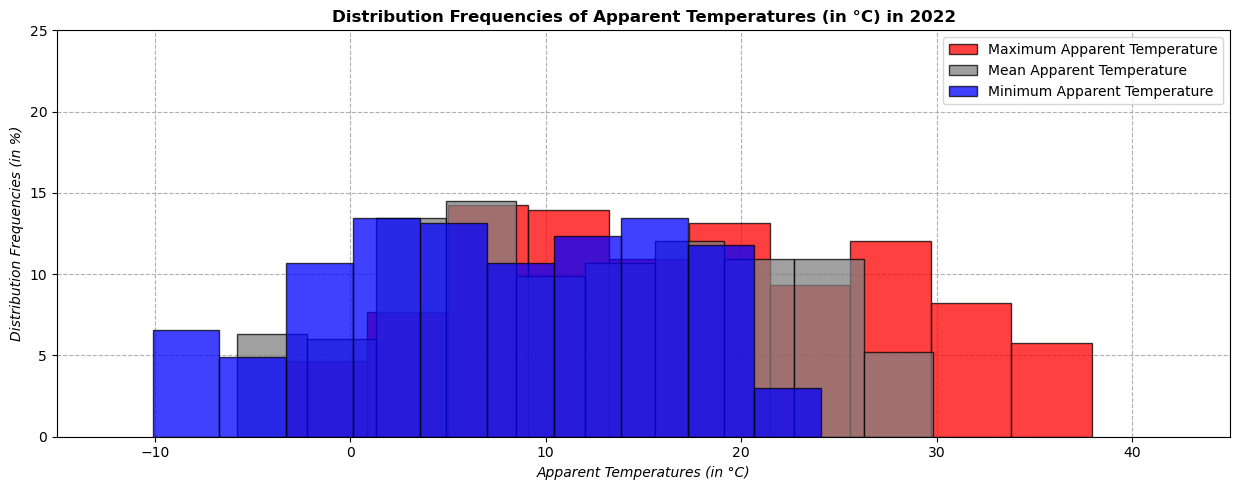

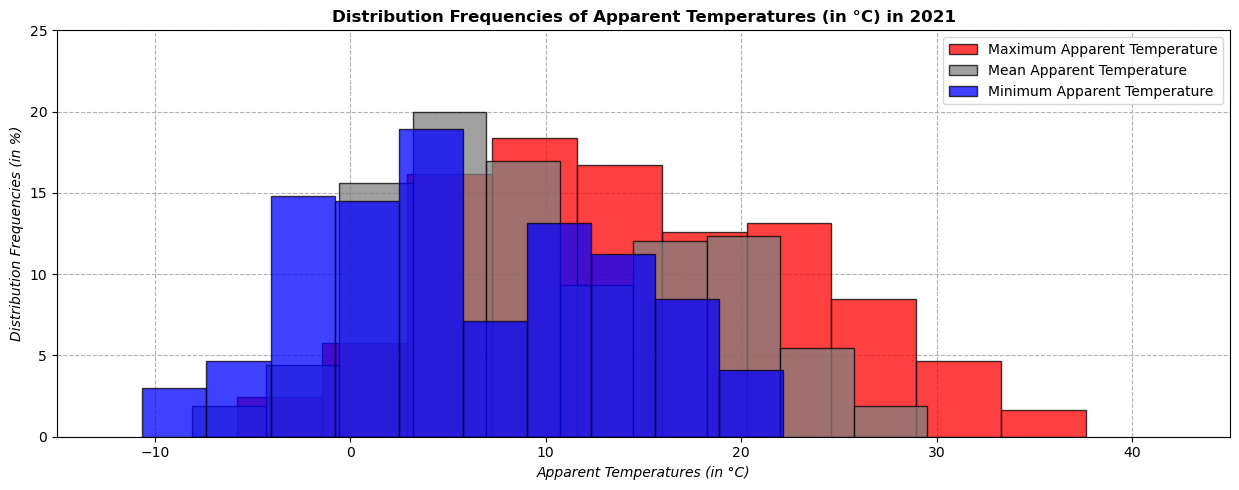

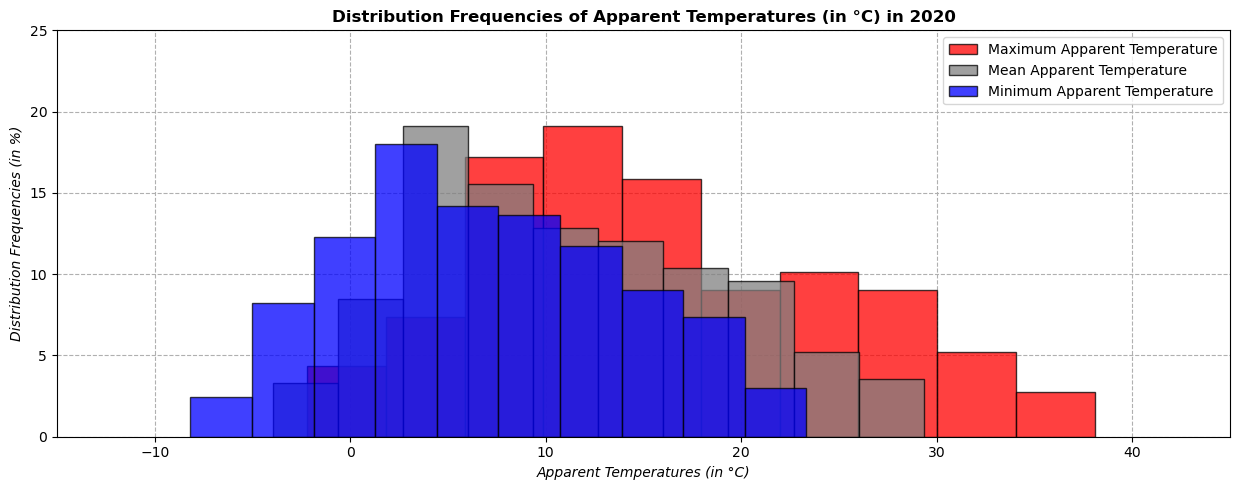

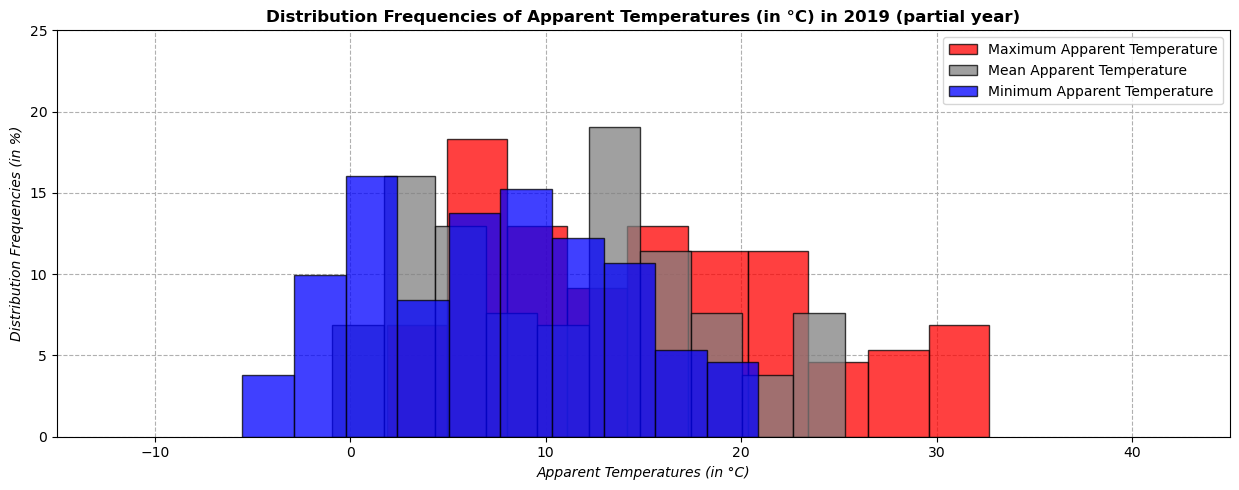

In [48]:
# Loop through each year and its corresponding dataframe to plot histograms of apparent temperatures distributions frequencies
for year_of_weather_cleaned_df, weather_cleaned_df_by_year in zip(years_of_weather_cleaned_df, weather_cleaned_dfs_by_year):
    visualize_histograms_of_apparent_temperatures_distribution_frequencies(
        year_of_weather_cleaned_df, 
        {
            "Maximum Apparent Temperature": ("red", weather_cleaned_df_by_year["apparent_temperature_max"]),
            "Mean Apparent Temperature": ("grey", weather_cleaned_df_by_year["apparent_temperature_mean"]),
            "Minimum Apparent Temperature": ("blue", weather_cleaned_df_by_year["apparent_temperature_min"])
        }
    )

#### Comment the Distributions for each year

In [49]:
# Loop through each year and its corresponding dataframe to comment the distributions
for year_of_weather_cleaned_df, weather_cleaned_df_by_year in zip(years_of_weather_cleaned_df, weather_cleaned_dfs_by_year):
    distribution = check_distribution(weather_cleaned_df_by_year, "apparent_temperature_mean")
    print(f"For the year {year_of_weather_cleaned_df}:")
    print(f"The Range of mean apparent temperatures is {distribution['range']}°C.")
    print(f"The Spread (aka. IQR) is {distribution['spread']}°C.")
    print(f"The Median is {distribution['median']}°C.")
    print(f"The Mean is {distribution['mean']}°C.")
    print(f"The Mode(s) is(are) {distribution['rounded_modes_list']}°C.")
    print(f"There are {distribution['outliers_count']} Outliers.")
    print(f"The Skewness is {distribution['skewness']}.")
    print()

For the year 2024 (partial year):
The Range of mean apparent temperatures is 34.8°C.
The Spread (aka. IQR) is 12.15°C.
The Median is 12.15°C.
The Mean is 13.16°C.
The Mode(s) is(are) [6.6, 9.4, 14.5]°C.
There are 0 Outliers.
The Skewness is 0.26.

For the year 2023:
The Range of mean apparent temperatures is 40.7°C.
The Spread (aka. IQR) is 14.6°C.
The Median is 12.4°C.
The Mean is 13.16°C.
The Mode(s) is(are) [5.9, 6.4, 9.9, 21.9]°C.
There are 0 Outliers.
The Skewness is 0.03.

For the year 2022:
The Range of mean apparent temperatures is 35.6°C.
The Spread (aka. IQR) is 15.1°C.
The Median is 13.7°C.
The Mean is 13.87°C.
The Mode(s) is(are) [19.8]°C.
There are 0 Outliers.
The Skewness is -0.01.

For the year 2021:
The Range of mean apparent temperatures is 37.6°C.
The Spread (aka. IQR) is 12.7°C.
The Median is 10.5°C.
The Mean is 11.78°C.
The Mode(s) is(are) [3.9]°C.
There are 0 Outliers.
The Skewness is 0.23.

For the year 2020:
The Range of mean apparent temperatures is 33.3°C.
The 

#### Visualize the Patterns for each year

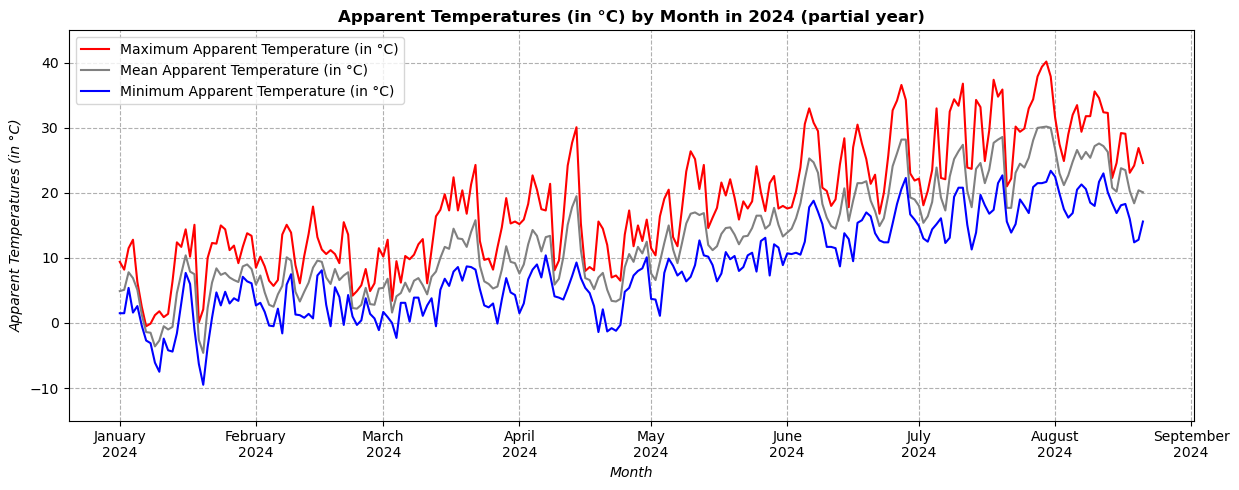

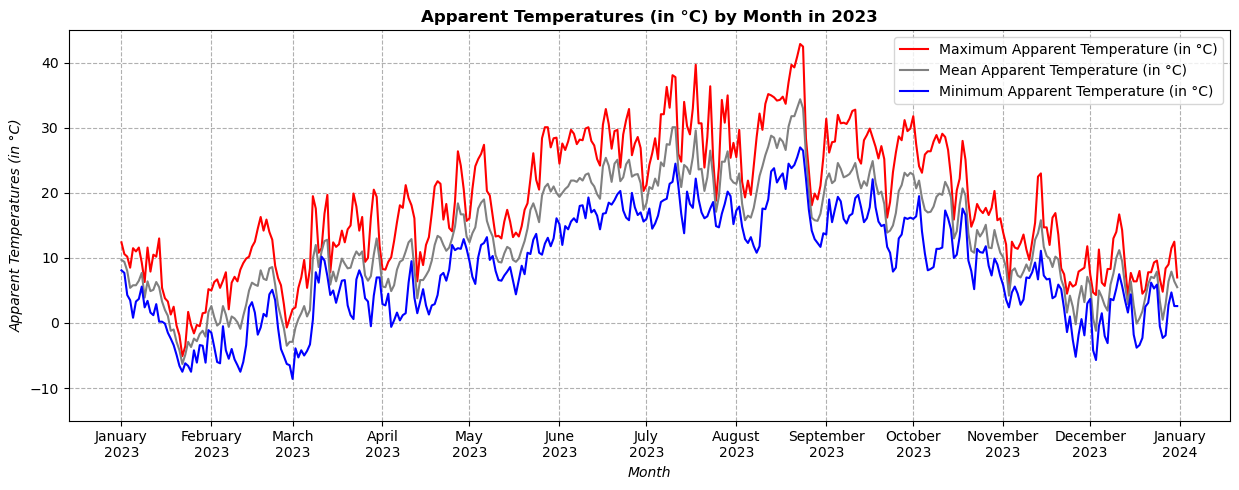

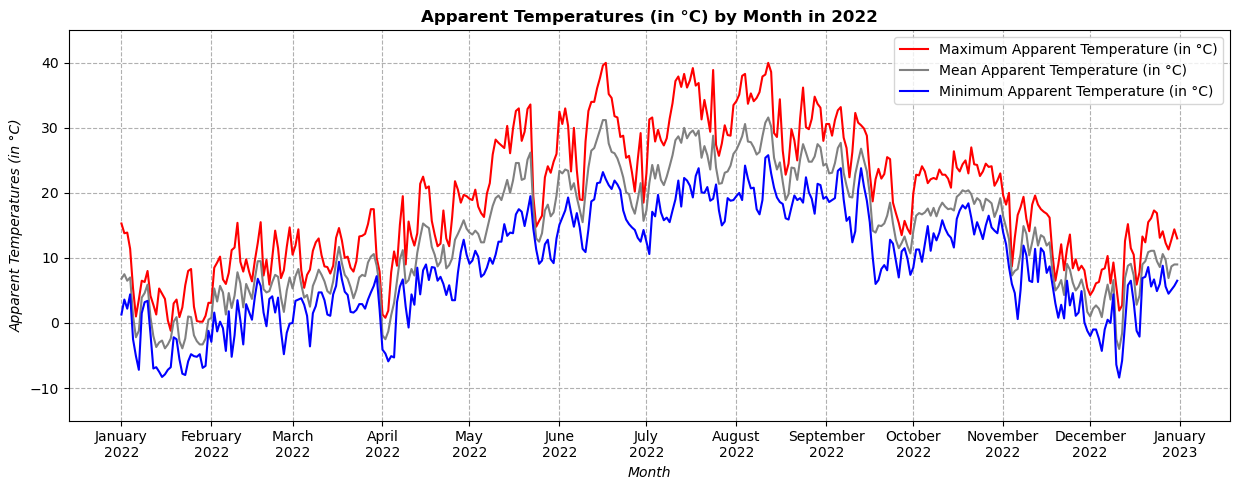

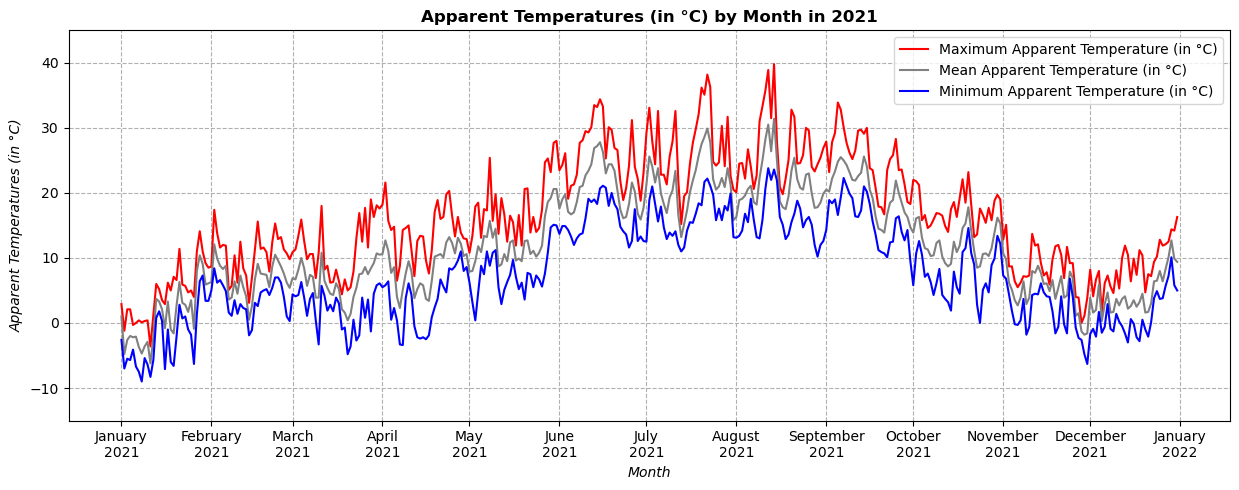

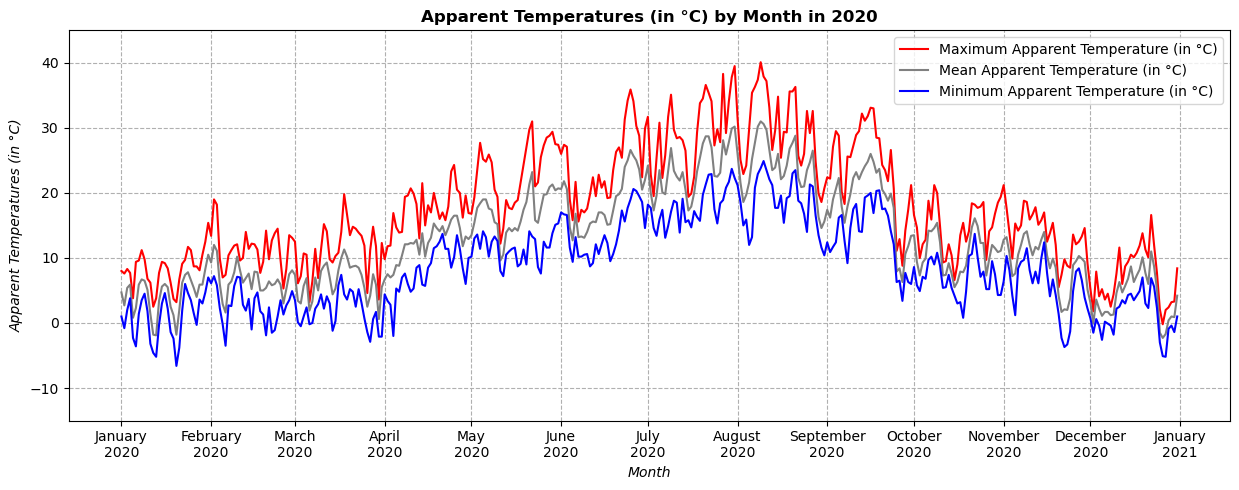

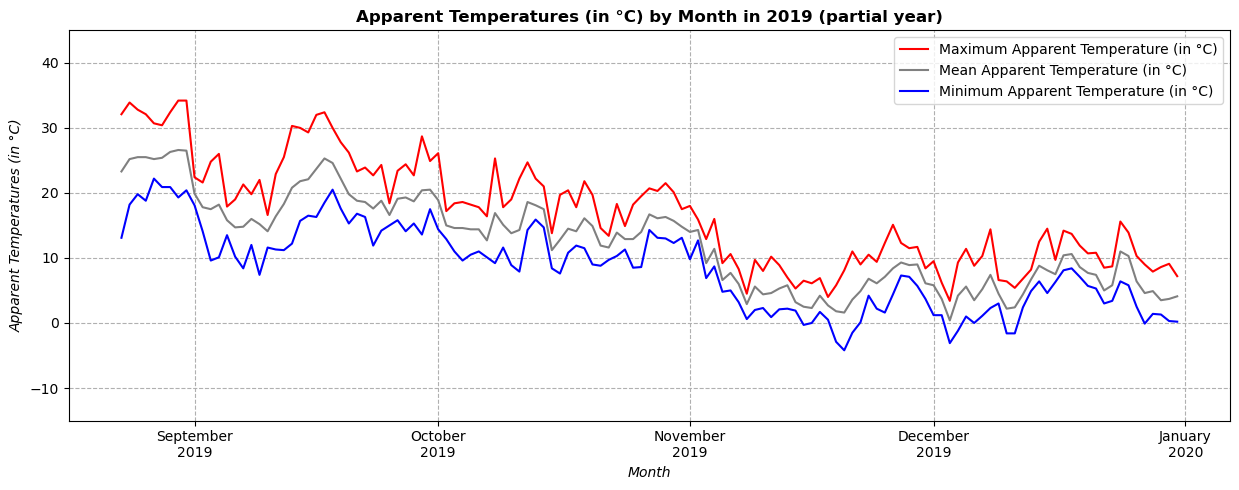

In [50]:
# Loop through each year and its corresponding dataframe to plot lineplots of apparent temperatures patterns
for year_of_weather_cleaned_df, weather_cleaned_df_by_year in zip(years_of_weather_cleaned_df, weather_cleaned_dfs_by_year):
    visualize_lineplots_of_apparent_temperatures_patterns(year_of_weather_cleaned_df, weather_cleaned_df_by_year)

#### Comment the Patterns for each year

Apart from 2019 and 2024 (partial years), there seems to be a pattern of temperatures increasing from April to the end of June, remaining stable from July to the end of September, decreasing from October to the end of December and remaining stable from January to the end of March of the following year.
It corresponds to the 4 seasons.

---
## Model the Data

### Prepare the Data to Model

In [53]:
# Prepare the data to model
weather_cleaned_model_df = weather_cleaned_df[[
    "apparent_temperature_max",
    "apparent_temperature_mean",
    "apparent_temperature_min",
    "temperature_2m_max",
    "temperature_2m_mean",
    "temperature_2m_min",
    "shortwave_radiation_sum",
    "global_tilted_irradiance",
    "soil_temperature_0_to_7cm",
    "soil_temperature_7_to_28cm",
    "soil_temperature_28_to_100cm",
    "dew_point_2m",
    "vapour_pressure_deficit",
    "et0_fao_evapotranspiration",
    "soil_moisture_0_to_7cm",
    "soil_moisture_7_to_28cm",
    "soil_moisture_28_to_100cm",
    "daylight_duration",
    "sunshine_duration",
    "direct_radiation",
    "direct_normal_irradiance",
    "cloud_cover",
    "relative_humidity_2m", 
    "month"]].copy()

# Add a column for the seasons
season_mapping = {
    "December": "Winter", "January": "Winter", "February": "Winter",
    "March": "Spring", "April": "Spring", "May": "Spring",
    "June": "Summer", "July": "Summer", "August": "Summer",
    "September": "Fall", "October": "Fall", "November": "Fall"
}
weather_cleaned_model_df["season"] = weather_cleaned_model_df["month"].map(season_mapping)
weather_cleaned_model_df.drop(columns = "month", inplace = True)
weather_cleaned_model_df = pd.get_dummies(weather_cleaned_model_df, columns = ["season"], drop_first = False)
weather_cleaned_model_df = weather_cleaned_model_df.astype(int)

In [54]:
# Check the dataframe
check_dataframe(weather_cleaned_model_df)

GENERAL INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   apparent_temperature_max      1826 non-null   int32
 1   apparent_temperature_mean     1826 non-null   int32
 2   apparent_temperature_min      1826 non-null   int32
 3   temperature_2m_max            1826 non-null   int32
 4   temperature_2m_mean           1826 non-null   int32
 5   temperature_2m_min            1826 non-null   int32
 6   shortwave_radiation_sum       1826 non-null   int32
 7   global_tilted_irradiance      1826 non-null   int32
 8   soil_temperature_0_to_7cm     1826 non-null   int32
 9   soil_temperature_7_to_28cm    1826 non-null   int32
 10  soil_temperature_28_to_100cm  1826 non-null   int32
 11  dew_point_2m                  1826 non-null   int32
 12  vapour_pressure_deficit       1826 non-null   int32
 13  et0_fao_evap

### Train the Model

In [55]:
# Define the correlated values
X = weather_cleaned_model_df[[
    "temperature_2m_max",
    "temperature_2m_mean",
    "temperature_2m_min",
    "shortwave_radiation_sum",
    "global_tilted_irradiance",
    "soil_temperature_0_to_7cm",
    "soil_temperature_7_to_28cm",
    "soil_temperature_28_to_100cm",
    "dew_point_2m",
    "vapour_pressure_deficit",
    "et0_fao_evapotranspiration",
    "soil_moisture_0_to_7cm",
    "soil_moisture_7_to_28cm",
    "soil_moisture_28_to_100cm",
    "daylight_duration",
    "sunshine_duration",
    "direct_radiation",
    "direct_normal_irradiance",
    "cloud_cover",
    "relative_humidity_2m",
    "season_Fall",
    "season_Spring",
    "season_Summer",
    "season_Winter"
]]

# Define the values to predict
y = weather_cleaned_model_df[[
    "apparent_temperature_max",
    "apparent_temperature_mean",
    "apparent_temperature_min"
]]

# Standardize the features
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Train the model (with "Train, Test, Split")
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, train_size = 0.75, shuffle = True, random_state = 42)
weather_model = LinearRegression().fit(X_train, y_train)

# Make predictions
y_train_predictions = weather_model.predict(X_train)
y_test_predictions = weather_model.predict(X_test)

### Evaluate the Model

In [57]:
# Extract the predictions for each apparent temperatures type
y_train_apparent_temperature_max_predictions = y_train_predictions[:, 0]
y_test_apparent_temperature_max_predictions = y_test_predictions[:, 0]
y_train_apparent_temperature_mean_predictions = y_train_predictions[:, 1]
y_test_apparent_temperature_mean_predictions = y_test_predictions[:, 1]
y_train_apparent_temperature_min_predictions = y_train_predictions[:, 2]
y_test_apparent_temperature_min_predictions = y_test_predictions[:, 2]

# Evaluate the metrics for the maximum apparent temperatures predictions
# Calculate the R² scores
r2_train_apparent_temperature_max = r2_score(y_train["apparent_temperature_max"], y_train_apparent_temperature_max_predictions)
r2_test_apparent_temperature_max = r2_score(y_test["apparent_temperature_max"], y_test_apparent_temperature_max_predictions)
# Calculate the Mean Squared Error (MSE)
mse_train_apparent_temperature_max = mean_squared_error(y_train["apparent_temperature_max"], y_train_apparent_temperature_max_predictions)
mse_test_apparent_temperature_max = mean_squared_error(y_test["apparent_temperature_max"], y_test_apparent_temperature_max_predictions)
# Calculate the Mean Absolute Error (MAE)
mae_train_apparent_temperature_max = mean_absolute_error(y_train["apparent_temperature_max"], y_train_apparent_temperature_max_predictions)
mae_test_apparent_temperature_max = mean_absolute_error(y_test["apparent_temperature_max"], y_test_apparent_temperature_max_predictions)

# Evaluate the metrics for the mean apparent temperatures predictions
# Calculate the R² scores
r2_train_apparent_temperature_mean = r2_score(y_train["apparent_temperature_mean"], y_train_apparent_temperature_mean_predictions)
r2_test_apparent_temperature_mean = r2_score(y_test["apparent_temperature_mean"], y_test_apparent_temperature_mean_predictions)
# Calculate the Mean Squared Error (MSE)
mse_train_apparent_temperature_mean = mean_squared_error(y_train["apparent_temperature_mean"], y_train_apparent_temperature_mean_predictions)
mse_test_apparent_temperature_mean = mean_squared_error(y_test["apparent_temperature_mean"], y_test_apparent_temperature_mean_predictions)
# Calculate the Mean Absolute Error (MAE)
mae_train_apparent_temperature_mean = mean_absolute_error(y_train["apparent_temperature_mean"], y_train_apparent_temperature_mean_predictions)
mae_test_apparent_temperature_mean = mean_absolute_error(y_test["apparent_temperature_mean"], y_test_apparent_temperature_mean_predictions)

# Evaluate the metrics for the minimum apparent temperatures predictions
# Calculate the R² scores
r2_train_apparent_temperature_min = r2_score(y_train["apparent_temperature_min"], y_train_apparent_temperature_min_predictions)
r2_test_apparent_temperature_min = r2_score(y_test["apparent_temperature_min"], y_test_apparent_temperature_min_predictions)
# Calculate the Mean Squared Error (MSE)
mse_train_apparent_temperature_min = mean_squared_error(y_train["apparent_temperature_min"], y_train_apparent_temperature_min_predictions)
mse_test_apparent_temperature_min = mean_squared_error(y_test["apparent_temperature_min"], y_test_apparent_temperature_min_predictions)
# Calculate the Mean Absolute Error (MAE)
mae_train_apparent_temperature_min = mean_absolute_error(y_train["apparent_temperature_min"], y_train_apparent_temperature_min_predictions)
mae_test_apparent_temperature_min = mean_absolute_error(y_test["apparent_temperature_min"], y_test_apparent_temperature_min_predictions)

# Perform a Cross-Validation on the model
cv_scores = cross_val_score(weather_model, scaled_X, y, cv = 5, scoring = "r2")

# Store a sample of apparent temperatures and their predictions in a dataframe
sample_of_apparent_temperatures_predictions = y_test_predictions[-5:]
sample_of_apparent_temperatures = y_test[-5:]
sample_of_apparent_temperatures_predictions_df = pd.DataFrame(
    {
        "apparent_temperature_max": sample_of_apparent_temperatures["apparent_temperature_max"].values,
        "predicted_apparent_temperature_max": sample_of_apparent_temperatures_predictions[:, 0].round(2),
        "apparent_temperature_mean": sample_of_apparent_temperatures["apparent_temperature_mean"].values,
        "predicted_apparent_temperature_mean": sample_of_apparent_temperatures_predictions[:, 1].round(2),
        "apparent_temperature_min": sample_of_apparent_temperatures["apparent_temperature_min"].values,
        "predicted_apparent_temperature_min": sample_of_apparent_temperatures_predictions[:, 2].round(2)
    }
)

# Print the results of the evaluation
print("METRICS ON THE OVERALL MODEL")
print()
print(f"Cross-Validation R² scores: {cv_scores}")
print(f"Mean Cross-Validation R² score: {cv_scores.mean():.4f}")
print(f"Standard-Deviation Cross-Validation R² score: {cv_scores.std():.4f}")
print()
print()
print("METRICS ON THE MAXIMUM APPARENT TEMPERATURES")
print()
print(f"R² Score for the training dataset: {r2_train_apparent_temperature_max:.4f}")
print(f"R² Score for the test dataset: {r2_test_apparent_temperature_max:.4f}")
print(f"MSE for the training dataset: {mse_train_apparent_temperature_max:.2f}")
print(f"MSE for the test dataset: {mse_test_apparent_temperature_max:.2f}")
print(f"MAE for the training dataset: {mae_train_apparent_temperature_max:.2f}")
print(f"MAE for the test dataset: {mae_test_apparent_temperature_max:.2f}")
print()
print()
print("METRICS ON THE MEAN APPARENT TEMPERATURES")
print()
print(f"R² Score for the training dataset: {r2_train_apparent_temperature_mean:.4f}")
print(f"R² Score for the test dataset: {r2_test_apparent_temperature_mean:.4f}")
print(f"MSE for the training dataset: {mse_train_apparent_temperature_mean:.2f}")
print(f"MSE for the test dataset: {mse_test_apparent_temperature_mean:.2f}")
print(f"MAE for the training dataset: {mae_train_apparent_temperature_mean:.2f}")
print(f"MAE for the test dataset: {mae_test_apparent_temperature_mean:.2f}")
print()
print()
print("METRICS ON THE MINIMUM APPARENT TEMPERATURES")
print()
print(f"R² Score for the training dataset: {r2_train_apparent_temperature_min:.4f}")
print(f"R² Score for the test dataset: {r2_test_apparent_temperature_min:.4f}")
print(f"MSE for the training dataset: {mse_train_apparent_temperature_min:.2f}")
print(f"MSE for the test dataset: {mse_test_apparent_temperature_min:.2f}")
print(f"MAE for the training dataset: {mae_train_apparent_temperature_min:.2f}")
print(f"MAE for the test dataset: {mae_test_apparent_temperature_min:.2f}")
print()
print()
print("SAMPLE OF APPARENT TEMPERATURES AND PREDICTIONS")
print(sample_of_apparent_temperatures_predictions_df)
print()

METRICS ON THE OVERALL MODEL

Cross-Validation R² scores: [0.98661785 0.98393877 0.98881817 0.98954263 0.98651703]
Mean Cross-Validation R² score: 0.9871
Standard-Deviation Cross-Validation R² score: 0.0020


METRICS ON THE MAXIMUM APPARENT TEMPERATURES

R² Score for the training dataset: 0.9859
R² Score for the test dataset: 0.9851
MSE for the training dataset: 1.26
MSE for the test dataset: 1.36
MAE for the training dataset: 0.89
MAE for the test dataset: 0.91


METRICS ON THE MEAN APPARENT TEMPERATURES

R² Score for the training dataset: 0.9910
R² Score for the test dataset: 0.9894
MSE for the training dataset: 0.61
MSE for the test dataset: 0.73
MAE for the training dataset: 0.62
MAE for the test dataset: 0.65


METRICS ON THE MINIMUM APPARENT TEMPERATURES

R² Score for the training dataset: 0.9880
R² Score for the test dataset: 0.9851
MSE for the training dataset: 0.67
MSE for the test dataset: 0.82
MAE for the training dataset: 0.64
MAE for the test dataset: 0.67


SAMPLE OF APPA

The model seems to perform consistently across different subsets (high Cross-validation R² scores, with Mean close to 1 and Standard deviation close to 0).

It explains nearly all the variance in the target variable for both the training and test datasets (R² scores are very close to 1), with little overfitting (the R² score on the test dataset is inferior to the R² score on the training dataset).

Its predictions are close to the actual values (low MSE and MAE) and it seems to generalize well to unseen data (small difference between the training dataset and the test dataset).

---
## Solve the Problem (*work in progress*)

Next step: 
* Find a way to determine the apparent temperatures for the next 7 days

Encountered problems:
* Model trained on a splitted dataset
* Future features (temperatures, humidity,...) must be known to predict future apparent temperatures  